In [1]:
"""
This module defines export functions for decision trees.
"""

# Authors: Gilles Louppe <g.louppe@gmail.com>
#          Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Brian Holt <bdholt1@gmail.com>
#          Noel Dawe <noel@dawe.me>
#          Satrajit Gosh <satrajit.ghosh@gmail.com>
#          Trevor Stephens <trev.stephens@gmail.com>
#          Li Li <aiki.nogard@gmail.com>
#          Giuseppe Vettigli <vettigli@gmail.com>
# License: BSD 3 clause
# import warnings
# from io import StringIO

# from numbers import Integral

# import numpy as np

# from ..utils.validation import check_is_fitted

# from . import _criterion
# from . import _tree
# from ._reingold_tilford import buchheim, Tree
# from . import DecisionTreeClassifier


def _color_brew(n):
    """Generate n colors with equally spaced hues.

    Parameters
    ----------
    n : int
        The number of colors required.

    Returns
    -------
    color_list : list, length n
        List of n tuples of form (R, G, B) being the components of each color.
    """
    color_list = []

    # Initialize saturation & value; calculate chroma & value shift
    s, v = 0.75, 0.9
    c = s * v
    m = v - c

    for h in np.arange(25, 385, 360. / n).astype(int):
        # Calculate some intermediate values
        h_bar = h / 60.
        x = c * (1 - abs((h_bar % 2) - 1))
        # Initialize RGB with same hue & chroma as our color
        rgb = [(c, x, 0),
               (x, c, 0),
               (0, c, x),
               (0, x, c),
               (x, 0, c),
               (c, 0, x),
               (c, x, 0)]
        r, g, b = rgb[int(h_bar)]
        # Shift the initial RGB values to match value and store
        rgb = [(int(255 * (r + m))),
               (int(255 * (g + m))),
               (int(255 * (b + m)))]
        color_list.append(rgb)

    return color_list


class Sentinel(object):
    def __repr__(self):
        return '"tree.dot"'


SENTINEL = Sentinel()


def plot_treez(decision_tree, max_depth=None, feature_names=None,
              class_names=None, label='all', filled=False,
              impurity=True, node_ids=False,
              proportion=False, rotate=False, rounded=False,
              precision=3, ax=None, fontsize=None):
    """Plot a decision tree.

    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    This function requires matplotlib, and works best with matplotlib >= 1.5.

    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.

    Read more in the :ref:`User Guide <tree>`.

    .. versionadded:: 0.21

    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be exported to GraphViz.

    max_depth : int, optional (default=None)
        The maximum depth of the representation. If None, the tree is fully
        generated.

    feature_names : list of strings, optional (default=None)
        Names of each of the features.

    class_names : list of strings, bool or None, optional (default=None)
        Names of each of the target classes in ascending numerical order.
        Only relevant for classification and not supported for multi-output.
        If ``True``, shows a symbolic representation of the class name.

    label : {'all', 'root', 'none'}, optional (default='all')
        Whether to show informative labels for impurity, etc.
        Options include 'all' to show at every node, 'root' to show only at
        the top root node, or 'none' to not show at any node.

    filled : bool, optional (default=False)
        When set to ``True``, paint nodes to indicate majority class for
        classification, extremity of values for regression, or purity of node
        for multi-output.

    impurity : bool, optional (default=True)
        When set to ``True``, show the impurity at each node.

    node_ids : bool, optional (default=False)
        When set to ``True``, show the ID number on each node.

    proportion : bool, optional (default=False)
        When set to ``True``, change the display of 'values' and/or 'samples'
        to be proportions and percentages respectively.

    rotate : bool, optional (default=False)
        When set to ``True``, orient tree left to right rather than top-down.

    rounded : bool, optional (default=False)
        When set to ``True``, draw node boxes with rounded corners and use
        Helvetica fonts instead of Times-Roman.

    precision : int, optional (default=3)
        Number of digits of precision for floating point in the values of
        impurity, threshold and value attributes of each node.

    ax : matplotlib axis, optional (default=None)
        Axes to plot to. If None, use current axis. Any previous content
        is cleared.

    fontsize : int, optional (default=None)
        Size of text font. If None, determined automatically to fit figure.

    Returns
    -------
    annotations : list of artists
        List containing the artists for the annotation boxes making up the
        tree.

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn import tree

    >>> clf = tree.DecisionTreeClassifier(random_state=0)
    >>> iris = load_iris()

    >>> clf = clf.fit(iris.data, iris.target)
    >>> tree.plot_tree(clf)  # doctest: +SKIP
    [Text(251.5,345.217,'X[3] <= 0.8...

    """
    exporter = _MPLTreeExporter(
        max_depth=max_depth, feature_names=feature_names,
        class_names=class_names, label=label, filled=filled,
        impurity=impurity, node_ids=node_ids,
        proportion=proportion, rotate=rotate, rounded=rounded,
        precision=precision, fontsize=fontsize)
    return exporter.export(decision_tree, ax=ax)


class _BaseTreeExporter(object):
    def __init__(self, max_depth=None, feature_names=None,
                 class_names=None, label='all', filled=False,
                 impurity=True, node_ids=False,
                 proportion=False, rotate=False, rounded=False,
                 precision=3, fontsize=None):
        self.max_depth = max_depth
        self.feature_names = feature_names
        self.class_names = class_names
        self.label = label
        self.filled = filled
        self.impurity = impurity
        self.node_ids = node_ids
        self.proportion = proportion
        self.rotate = rotate
        self.rounded = rounded
        self.precision = precision
        self.fontsize = fontsize

    def get_color(self, value):
        # Find the appropriate color & intensity for a node
        if self.colors['bounds'] is None:
            # Classification tree
            color = list(self.colors['rgb'][np.argmax(value)])
            sorted_values = sorted(value, reverse=True)
            if len(sorted_values) == 1:
                alpha = 0
            else:
                alpha = ((sorted_values[0] - sorted_values[1])
                         / (1 - sorted_values[1]))
        else:
            # Regression tree or multi-output
            color = list(self.colors['rgb'][0])
            alpha = ((value - self.colors['bounds'][0]) /
                     (self.colors['bounds'][1] - self.colors['bounds'][0]))
        # unpack numpy scalars
        alpha = float(alpha)
        # compute the color as alpha against white
        color = [int(round(alpha * c + (1 - alpha) * 255, 0)) for c in color]
        # Return html color code in #RRGGBB format
        return '#%2x%2x%2x' % tuple(color)

    def get_fill_color(self, tree, node_id):
        # Fetch appropriate color for node
        if 'rgb' not in self.colors:
            # Initialize colors and bounds if required
            self.colors['rgb'] = _color_brew(tree.n_classes[0])
            if tree.n_outputs != 1:
                # Find max and min impurities for multi-output
                self.colors['bounds'] = (np.min(-tree.impurity),
                                         np.max(-tree.impurity))
            elif (tree.n_classes[0] == 1 and
                  len(np.unique(tree.value)) != 1):
                # Find max and min values in leaf nodes for regression
                self.colors['bounds'] = (np.min(tree.value),
                                         np.max(tree.value))
        if tree.n_outputs == 1:
            node_val = (tree.value[node_id][0, :] /
                        tree.weighted_n_node_samples[node_id])
            if tree.n_classes[0] == 1:
                # Regression
                node_val = tree.value[node_id][0, :]
        else:
            # If multi-output color node by impurity
            node_val = -tree.impurity[node_id]
        return self.get_color(node_val)

    def node_to_str(self, tree, node_id, criterion):
        # Generate the node content string
        if tree.n_outputs == 1:
            value = tree.value[node_id][0, :]
        else:
            value = tree.value[node_id]

        # Should labels be shown?
        labels = (self.label == 'root' and node_id == 0) or self.label == 'all'

        characters = self.characters
        node_string = characters[-1]

        # Write node ID
        if self.node_ids:
            if labels:
                node_string += 'node '
            node_string += characters[0] + str(node_id) + characters[4]

        # Write decision criteria
        if tree.children_left[node_id] != _tree.TREE_LEAF:
            # Always write node decision criteria, except for leaves
            if self.feature_names is not None:
                feature = self.feature_names[tree.feature[node_id]]
            else:
                feature = "X%s%s%s" % (characters[1],
                                       tree.feature[node_id],
                                       characters[2])
            node_string += '%s %s %s%s' % (feature,
                                           characters[3],
                                           round(tree.threshold[node_id],
                                                 self.precision),
                                           characters[4])

        # Write impurity
        if self.impurity:
            if isinstance(criterion, _criterion.FriedmanMSE):
                criterion = "friedman_mse"
            elif not isinstance(criterion, str):
                criterion = "impurity"
            if labels:
                node_string += '%s = ' % criterion
            node_string += (str(round(tree.impurity[node_id], self.precision))
                            + characters[4])

        # Write node sample count
        if labels:
            node_string += 'samples = '
        if self.proportion:
            percent = (100. * tree.n_node_samples[node_id] /
                       float(tree.n_node_samples[0]))
            node_string += (str(round(percent, 1)) + '%' +
                            characters[4])
        else:
            node_string += (str(tree.n_node_samples[node_id]) +
                            characters[4])

        # Write node class distribution / regression value
        if self.proportion and tree.n_classes[0] != 1:
            # For classification this will show the proportion of samples
            value = value / tree.weighted_n_node_samples[node_id]
        if labels:
            node_string += 'value = '
        if tree.n_classes[0] == 1:
            # Regression
            value_text = np.around(value, self.precision)
        elif self.proportion:
            # Classification
            value_text = np.around(value, self.precision)
        elif np.all(np.equal(np.mod(value, 1), 0)):
            # Classification without floating-point weights
            value_text = value.astype(int)
        else:
            # Classification with floating-point weights
            value_text = np.around(value, self.precision)
        # Strip whitespace
        value_text = str(value_text.astype('S32')).replace("b'", "'")
        value_text = value_text.replace("' '", ", ").replace("'", "")
        if tree.n_classes[0] == 1 and tree.n_outputs == 1:
            value_text = value_text.replace("[", "").replace("]", "")
        value_text = value_text.replace("\n ", characters[4])
        node_string += value_text + characters[4]

        # Write node majority class
        if (self.class_names is not None and
                tree.n_classes[0] != 1 and
                tree.n_outputs == 1):
            # Only done for single-output classification trees
            if labels:
                node_string += 'class = '
            if self.class_names is not True:
                class_name = self.class_names[np.argmax(value)]
            else:
                class_name = "y%s%s%s" % (characters[1],
                                          np.argmax(value),
                                          characters[2])
            node_string += class_name

        # Clean up any trailing newlines
        if node_string.endswith(characters[4]):
            node_string = node_string[:-len(characters[4])]

        return node_string + characters[5]


class _DOTTreeExporter(_BaseTreeExporter):
    def __init__(self, out_file=SENTINEL, max_depth=None,
                 feature_names=None, class_names=None, label='all',
                 filled=False, leaves_parallel=False, impurity=True,
                 node_ids=False, proportion=False, rotate=False, rounded=False,
                 special_characters=False, precision=3):

        super().__init__(
            max_depth=max_depth, feature_names=feature_names,
            class_names=class_names, label=label, filled=filled,
            impurity=impurity,
            node_ids=node_ids, proportion=proportion, rotate=rotate,
            rounded=rounded,
            precision=precision)
        self.leaves_parallel = leaves_parallel
        self.out_file = out_file
        self.special_characters = special_characters

        # PostScript compatibility for special characters
        if special_characters:
            self.characters = ['&#35;', '<SUB>', '</SUB>', '&le;', '<br/>',
                               '>', '<']
        else:
            self.characters = ['#', '[', ']', '<=', '\\n', '"', '"']

        # validate
        if isinstance(precision, Integral):
            if precision < 0:
                raise ValueError("'precision' should be greater or equal to 0."
                                 " Got {} instead.".format(precision))
        else:
            raise ValueError("'precision' should be an integer. Got {}"
                             " instead.".format(type(precision)))

        # The depth of each node for plotting with 'leaf' option
        self.ranks = {'leaves': []}
        # The colors to render each node with
        self.colors = {'bounds': None}

    def export(self, decision_tree):
        # Check length of feature_names before getting into the tree node
        # Raise error if length of feature_names does not match
        # n_features_ in the decision_tree
        if self.feature_names is not None:
            if len(self.feature_names) != decision_tree.n_features_:
                raise ValueError("Length of feature_names, %d "
                                 "does not match number of features, %d"
                                 % (len(self.feature_names),
                                    decision_tree.n_features_))
        # each part writes to out_file
        self.head()
        # Now recurse the tree and add node & edge attributes
        if isinstance(decision_tree, _tree.Tree):
            self.recurse(decision_tree, 0, criterion="impurity")
        else:
            self.recurse(decision_tree.tree_, 0,
                         criterion=decision_tree.criterion)

        self.tail()

    def tail(self):
        # If required, draw leaf nodes at same depth as each other
        if self.leaves_parallel:
            for rank in sorted(self.ranks):
                self.out_file.write(
                    "{rank=same ; " +
                    "; ".join(r for r in self.ranks[rank]) + "} ;\n")
        self.out_file.write("}")

    def head(self):
        self.out_file.write('digraph Tree {\n')

        # Specify node aesthetics
        self.out_file.write('node [shape=box')
        rounded_filled = []
        if self.filled:
            rounded_filled.append('filled')
        if self.rounded:
            rounded_filled.append('rounded')
        if len(rounded_filled) > 0:
            self.out_file.write(
                ', style="%s", color="black"'
                % ", ".join(rounded_filled))
        if self.rounded:
            self.out_file.write(', fontname=helvetica')
        self.out_file.write('] ;\n')

        # Specify graph & edge aesthetics
        if self.leaves_parallel:
            self.out_file.write(
                'graph [ranksep=equally, splines=polyline] ;\n')
        if self.rounded:
            self.out_file.write('edge [fontname=helvetica] ;\n')
        if self.rotate:
            self.out_file.write('rankdir=LR ;\n')

    def recurse(self, tree, node_id, criterion, parent=None, depth=0):
        if node_id == _tree.TREE_LEAF:
            raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)

        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # Add node with description
        if self.max_depth is None or depth <= self.max_depth:

            # Collect ranks for 'leaf' option in plot_options
            if left_child == _tree.TREE_LEAF:
                self.ranks['leaves'].append(str(node_id))
            elif str(depth) not in self.ranks:
                self.ranks[str(depth)] = [str(node_id)]
            else:
                self.ranks[str(depth)].append(str(node_id))

            self.out_file.write(
                '%d [label=%s' % (node_id, self.node_to_str(tree, node_id,
                                                            criterion)))

            if self.filled:
                self.out_file.write(', fillcolor="%s"'
                                    % self.get_fill_color(tree, node_id))
            self.out_file.write('] ;\n')

            if parent is not None:
                # Add edge to parent
                self.out_file.write('%d -> %d' % (parent, node_id))
                if parent == 0:
                    # Draw True/False labels if parent is root node
                    angles = np.array([45, -45]) * ((self.rotate - .5) * -2)
                    self.out_file.write(' [labeldistance=2.5, labelangle=')
                    if node_id == 1:
                        self.out_file.write('%d, headlabel="True"]' %
                                            angles[0])
                    else:
                        self.out_file.write('%d, headlabel="False"]' %
                                            angles[1])
                self.out_file.write(' ;\n')

            if left_child != _tree.TREE_LEAF:
                self.recurse(tree, left_child, criterion=criterion,
                             parent=node_id, depth=depth + 1)
                self.recurse(tree, right_child, criterion=criterion,
                             parent=node_id, depth=depth + 1)

        else:
            self.ranks['leaves'].append(str(node_id))

            self.out_file.write('%d [label="(...)"' % node_id)
            if self.filled:
                # color cropped nodes grey
                self.out_file.write(', fillcolor="#C0C0C0"')
            self.out_file.write('] ;\n' % node_id)

            if parent is not None:
                # Add edge to parent
                self.out_file.write('%d -> %d ;\n' % (parent, node_id))


class _MPLTreeExporter(_BaseTreeExporter):
    def __init__(self, max_depth=None, feature_names=None,
                 class_names=None, label='all', filled=False,
                 impurity=True, node_ids=False,
                 proportion=False, rotate=False, rounded=False,
                 precision=3, fontsize=None):

        super().__init__(
            max_depth=max_depth, feature_names=feature_names,
            class_names=class_names, label=label, filled=filled,
            impurity=impurity, node_ids=node_ids, proportion=proportion,
            rotate=rotate, rounded=rounded, precision=precision)
        self.fontsize = fontsize

        # validate
        if isinstance(precision, Integral):
            if precision < 0:
                raise ValueError("'precision' should be greater or equal to 0."
                                 " Got {} instead.".format(precision))
        else:
            raise ValueError("'precision' should be an integer. Got {}"
                             " instead.".format(type(precision)))

        # The depth of each node for plotting with 'leaf' option
        self.ranks = {'leaves': []}
        # The colors to render each node with
        self.colors = {'bounds': None}

        self.characters = ['#', '[', ']', '<=', '\n', '', '']

        self.bbox_args = dict(fc='w')
        if self.rounded:
            self.bbox_args['boxstyle'] = "round"
        else:
            # matplotlib <1.5 requires explicit boxstyle
            self.bbox_args['boxstyle'] = "square"

        self.arrow_args = dict(arrowstyle="<-")

    def _make_tree(self, node_id, et, criterion, depth=0):
        # traverses _tree.Tree recursively, builds intermediate
        # "_reingold_tilford.Tree" object
        name = self.node_to_str(et, node_id, criterion=criterion)
        if (et.children_left[node_id] != _tree.TREE_LEAF
                and (self.max_depth is None or depth <= self.max_depth)):
            children = [self._make_tree(et.children_left[node_id], et,
                                        criterion, depth=depth + 1),
                        self._make_tree(et.children_right[node_id], et,
                                        criterion, depth=depth + 1)]
        else:
            return Tree(name, node_id)
        return Tree(name, node_id, *children)

    def export(self, decision_tree, ax=None):
        import matplotlib.pyplot as plt
        from matplotlib.text import Annotation
        if ax is None:
            ax = plt.gca()
        ax.clear()
        ax.set_axis_off()
        my_tree = self._make_tree(0, decision_tree.tree_, decision_tree.criterion)
        draw_tree = buchheim(my_tree)

        # important to make sure we're still
        # inside the axis after drawing the box
        # this makes sense because the width of a box
        # is about the same as the distance between boxes
        max_x, max_y = draw_tree.max_extents() + 1
        ax_width = ax.get_window_extent().width
        ax_height = ax.get_window_extent().height

        scale_x = ax_width / max_x
        scale_y = ax_height / max_y
        
 

        self.recurse(draw_tree, decision_tree.tree_, ax,
                     scale_x, scale_y, ax_height)

        anns = [ann for ann in ax.get_children()
                if isinstance(ann, Annotation)]

        #return 'end123'       

        # update sizes of all bboxes
        renderer = ax.figure.canvas.get_renderer()

        for ann in anns:
            ann.update_bbox_position_size(renderer)

        if self.fontsize is None:
            # get figure to data transform
            # adjust fontsize to avoid overlap
            # get max box width and height
            try:
                extents = [ann.get_bbox_patch().get_window_extent()
                           for ann in anns]
                max_width = max([extent.width for extent in extents])
                max_height = max([extent.height for extent in extents])
                # width should be around scale_x in axis coordinates
                size = anns[0].get_fontsize() * min(scale_x / max_width,
                                                    scale_y / max_height)
                for ann in anns:
                    ann.set_fontsize(size)
            except AttributeError:
                # matplotlib < 1.5
                warnings.warn("Automatic scaling of tree plots requires "
                              "matplotlib 1.5 or higher. Please specify "
                              "fontsize.")

        return anns, ax

    def recurse(self, node, tree, ax, scale_x, scale_y, height, depth=0):
        # need to copy bbox args because matplotib <1.5 modifies them
        kwargs = dict(bbox=self.bbox_args.copy(), ha='center', va='center',
                      zorder=100 - 10 * depth, xycoords='axes pixels')

        if self.fontsize is not None:
            kwargs['fontsize'] = self.fontsize

        # offset things by .5 to center them in plot
        xy = ((node.x + .5) * scale_x, height - (node.y + .5) * scale_y)

        if self.max_depth is None or depth <= self.max_depth:
            if self.filled:
                kwargs['bbox']['fc'] = self.get_fill_color(tree,
                                                           node.tree.node_id)
            if node.parent is None:
                # root
                ax.annotate(node.tree.label, xy, **kwargs)
            else:
                xy_parent = ((node.parent.x + .5) * scale_x,
                             height - (node.parent.y + .5) * scale_y)
                kwargs["arrowprops"] = self.arrow_args
                ax.annotate(node.tree.label, xy_parent, xy, **kwargs)
            for child in node.children:
                self.recurse(child, tree, ax, scale_x, scale_y, height,
                             depth=depth + 1)

        else:
            xy_parent = ((node.parent.x + .5) * scale_x,
                         height - (node.parent.y + .5) * scale_y)
            kwargs["arrowprops"] = self.arrow_args
            kwargs['bbox']['fc'] = 'grey'
            ax.annotate("\n  (...)  \n", xy_parent, xy, **kwargs)


def export_graphviz(decision_tree, out_file=None, max_depth=None,
                    feature_names=None, class_names=None, label='all',
                    filled=False, leaves_parallel=False, impurity=True,
                    node_ids=False, proportion=False, rotate=False,
                    rounded=False, special_characters=False, precision=3):
    """Export a decision tree in DOT format.

    This function generates a GraphViz representation of the decision tree,
    which is then written into `out_file`. Once exported, graphical renderings
    can be generated using, for example::

        $ dot -Tps tree.dot -o tree.ps      (PostScript format)
        $ dot -Tpng tree.dot -o tree.png    (PNG format)

    The sample counts that are shown are weighted with any sample_weights that
    might be present.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    decision_tree : decision tree classifier
        The decision tree to be exported to GraphViz.

    out_file : file object or string, optional (default=None)
        Handle or name of the output file. If ``None``, the result is
        returned as a string.

        .. versionchanged:: 0.20
            Default of out_file changed from "tree.dot" to None.

    max_depth : int, optional (default=None)
        The maximum depth of the representation. If None, the tree is fully
        generated.

    feature_names : list of strings, optional (default=None)
        Names of each of the features.

    class_names : list of strings, bool or None, optional (default=None)
        Names of each of the target classes in ascending numerical order.
        Only relevant for classification and not supported for multi-output.
        If ``True``, shows a symbolic representation of the class name.

    label : {'all', 'root', 'none'}, optional (default='all')
        Whether to show informative labels for impurity, etc.
        Options include 'all' to show at every node, 'root' to show only at
        the top root node, or 'none' to not show at any node.

    filled : bool, optional (default=False)
        When set to ``True``, paint nodes to indicate majority class for
        classification, extremity of values for regression, or purity of node
        for multi-output.

    leaves_parallel : bool, optional (default=False)
        When set to ``True``, draw all leaf nodes at the bottom of the tree.

    impurity : bool, optional (default=True)
        When set to ``True``, show the impurity at each node.

    node_ids : bool, optional (default=False)
        When set to ``True``, show the ID number on each node.

    proportion : bool, optional (default=False)
        When set to ``True``, change the display of 'values' and/or 'samples'
        to be proportions and percentages respectively.

    rotate : bool, optional (default=False)
        When set to ``True``, orient tree left to right rather than top-down.

    rounded : bool, optional (default=False)
        When set to ``True``, draw node boxes with rounded corners and use
        Helvetica fonts instead of Times-Roman.

    special_characters : bool, optional (default=False)
        When set to ``False``, ignore special characters for PostScript
        compatibility.

    precision : int, optional (default=3)
        Number of digits of precision for floating point in the values of
        impurity, threshold and value attributes of each node.

    Returns
    -------
    dot_data : string
        String representation of the input tree in GraphViz dot format.
        Only returned if ``out_file`` is None.

        .. versionadded:: 0.18

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn import tree

    >>> clf = tree.DecisionTreeClassifier()
    >>> iris = load_iris()

    >>> clf = clf.fit(iris.data, iris.target)
    >>> tree.export_graphviz(clf)
    'digraph Tree {...
    """

    check_is_fitted(decision_tree, 'tree_')
    own_file = False
    return_string = False
    try:
        if isinstance(out_file, str):
            out_file = open(out_file, "w", encoding="utf-8")
            own_file = True

        if out_file is None:
            return_string = True
            out_file = StringIO()

        exporter = _DOTTreeExporter(
            out_file=out_file, max_depth=max_depth,
            feature_names=feature_names, class_names=class_names, label=label,
            filled=filled, leaves_parallel=leaves_parallel, impurity=impurity,
            node_ids=node_ids, proportion=proportion, rotate=rotate,
            rounded=rounded, special_characters=special_characters,
            precision=precision)
        exporter.export(decision_tree)

        if return_string:
            return exporter.out_file.getvalue()

    finally:
        if own_file:
            out_file.close()


def _compute_depth(tree, node):
    """
    Returns the depth of the subtree rooted in node.
    """
    def compute_depth_(current_node, current_depth,
                       children_left, children_right, depths):
        depths += [current_depth]
        left = children_left[current_node]
        right = children_right[current_node]
        if left != -1 and right != -1:
            compute_depth_(left, current_depth+1,
                           children_left, children_right, depths)
            compute_depth_(right, current_depth+1,
                           children_left, children_right, depths)

    depths = []
    compute_depth_(node, 1, tree.children_left, tree.children_right, depths)
    return max(depths)


def export_text(decision_tree, feature_names=None, max_depth=10,
                spacing=3, decimals=2, show_weights=False):
    """Build a text report showing the rules of a decision tree.

    Note that backwards compatibility may not be supported.

    Parameters
    ----------
    decision_tree : object
        The decision tree estimator to be exported.
        It can be an instance of
        DecisionTreeClassifier or DecisionTreeRegressor.

    feature_names : list, optional (default=None)
        A list of length n_features containing the feature names.
        If None generic names will be used ("feature_0", "feature_1", ...).

    max_depth : int, optional (default=10)
        Only the first max_depth levels of the tree are exported.
        Truncated branches will be marked with "...".

    spacing : int, optional (default=3)
        Number of spaces between edges. The higher it is, the wider the result.

    decimals : int, optional (default=2)
        Number of decimal digits to display.

    show_weights : bool, optional (default=False)
        If true the classification weights will be exported on each leaf.
        The classification weights are the number of samples each class.

    Returns
    -------
    report : string
        Text summary of all the rules in the decision tree.

    Examples
    --------

    >>> from sklearn.datasets import load_iris
    >>> from sklearn.tree import DecisionTreeClassifier
    >>> from sklearn.tree.export import export_text
    >>> iris = load_iris()
    >>> X = iris['data']
    >>> y = iris['target']
    >>> decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
    >>> decision_tree = decision_tree.fit(X, y)
    >>> r = export_text(decision_tree, feature_names=iris['feature_names'])
    >>> print(r)
    |--- petal width (cm) <= 0.80
    |   |--- class: 0
    |--- petal width (cm) >  0.80
    |   |--- petal width (cm) <= 1.75
    |   |   |--- class: 1
    |   |--- petal width (cm) >  1.75
    |   |   |--- class: 2
    """
    check_is_fitted(decision_tree, 'tree_')
    tree_ = decision_tree.tree_
    class_names = decision_tree.classes_
    right_child_fmt = "{} {} <= {}\n"
    left_child_fmt = "{} {} >  {}\n"
    truncation_fmt = "{} {}\n"

    if max_depth < 0:
        raise ValueError("max_depth bust be >= 0, given %d" % max_depth)

    if (feature_names is not None and
            len(feature_names) != tree_.n_features):
        raise ValueError("feature_names must contain "
                         "%d elements, got %d" % (tree_.n_features,
                                                  len(feature_names)))

    if spacing <= 0:
        raise ValueError("spacing must be > 0, given %d" % spacing)

    if decimals < 0:
        raise ValueError("decimals must be >= 0, given %d" % decimals)

    if isinstance(decision_tree, DecisionTreeClassifier):
        value_fmt = "{}{} weights: {}\n"
        if not show_weights:
            value_fmt = "{}{}{}\n"
    else:
        value_fmt = "{}{} value: {}\n"

    if feature_names:
        feature_names_ = [feature_names[i] for i in tree_.feature]
    else:
        feature_names_ = ["feature_{}".format(i) for i in tree_.feature]

    export_text.report = ""

    def _add_leaf(value, class_name, indent):
        val = ''
        is_classification = isinstance(decision_tree,
                                       DecisionTreeClassifier)
        if show_weights or not is_classification:
            val = ["{1:.{0}f}, ".format(decimals, v) for v in value]
            val = '['+''.join(val)[:-2]+']'
        if is_classification:
            val += ' class: ' + str(class_name)
        export_text.report += value_fmt.format(indent, '', val)

    def print_tree_recurse(node, depth):
        indent = ("|" + (" " * spacing)) * depth
        indent = indent[:-spacing] + "-" * spacing

        value = None
        if tree_.n_outputs == 1:
            value = tree_.value[node][0]
        else:
            value = tree_.value[node].T[0]
        class_name = np.argmax(value)

        if (tree_.n_classes[0] != 1 and
                tree_.n_outputs == 1):
            class_name = class_names[class_name]

        if depth <= max_depth+1:
            info_fmt = ""
            info_fmt_left = info_fmt
            info_fmt_right = info_fmt

            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names_[node]
                threshold = tree_.threshold[node]
                threshold = "{1:.{0}f}".format(decimals, threshold)
                export_text.report += right_child_fmt.format(indent,
                                                             name,
                                                             threshold)
                export_text.report += info_fmt_left
                print_tree_recurse(tree_.children_left[node], depth+1)

                export_text.report += left_child_fmt.format(indent,
                                                            name,
                                                            threshold)
                export_text.report += info_fmt_right
                print_tree_recurse(tree_.children_right[node], depth+1)
            else:  # leaf
                _add_leaf(value, class_name, indent)
        else:
            subtree_depth = _compute_depth(tree_, node)
            if subtree_depth == 1:
                _add_leaf(value, class_name, indent)
            else:
                trunc_report = 'truncated branch of depth %d' % subtree_depth
                export_text.report += truncation_fmt.format(indent,
                                                            trunc_report)

    print_tree_recurse(0, 1)
    return export_text.report

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier #, plot_tree

# Load data
iris = load_iris()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)


In [3]:

from sklearn.tree import _tree
from sklearn.tree import _criterion
from sklearn.tree.export import *


annotations, fig = plot_treez(clf,filled=True)

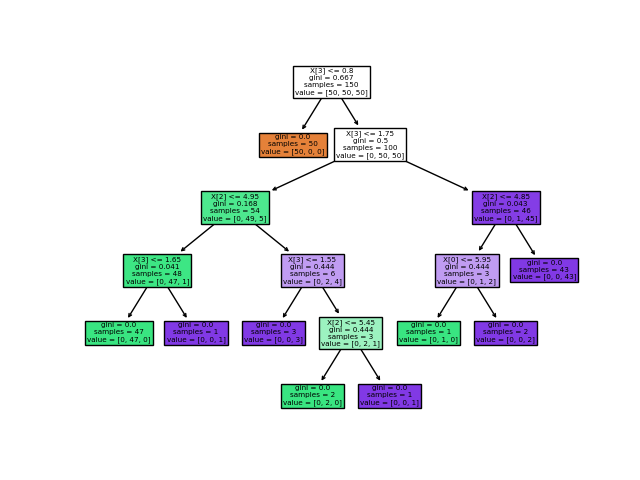

In [4]:
display(fig.figure)